### Run Code

Make sure the following libraries are installed before running the code below.  
The code sets a random seed to ensure repeatable results for each run, please run all cells below to complete the code run.

In [30]:
import numpy as np
import gym
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

In [31]:
# Set global random seed for reproducibility
GLOBAL_SEED = 99
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)

### Environment   
The system teaches the vehicle to drive in a safe and efficient way. It encourages the car to stay near the centerline (x = 0) and to keep a safe distance from obstacles. The reward system gives negative points when the car moves away from the center or gets too close to obstacles. It gives positive points when the car maintains a moderate speed between 5 and 10 units. If the car crashes into an obstacle or goes off the track, the system ends the turn and applies strong penalties. The turn also ends if the car comes to a complete stop, to make sure it keeps moving. This approach helps the car learn how to drive smoothly and avoid collisions.

1.State Space
The state space contains 6 dimensions:
the vehicle's position x and y, speed speed, and the distances between the vehicle and each obstacle dist1, dist2, dist3.

2.Action Space
The action space contains 5 possible actions:
Light Accelerate
Hard Accelerate
Brake
Steer Left
Steer Right

3.Reward Function
Reward for Staying Close to the Center Line: -abs(x), the further the vehicle deviates from the center line, the lower the reward. Penalty for Being Close to Obstacles: The greater the distance from obstacles, the smaller the penalty. Reward for Maintaining a Moderate Speed: When the speed is within the range [5, 10], a reward of +10 is given. Penalty for Collision: -50 for hitting an obstacle, -100 for going out of bounds.

With this design, the reward function guides the agent to learn how to stay in the center of the road, keep a safe distance from obstacles, and maintain an appropriate speed, thereby simulating the behavior of a vehicle on an actual road. This design helps the reinforcement learning agent learn to drive safely and efficiently while enhancing its adaptability to the environment.

In [32]:
# Custom Environment
class CarEnv(gym.Env):
    def __init__(self, seed=GLOBAL_SEED):
        # Initialize the custom car environment
        super(CarEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(5)  # Actions modified: more detailed actions 
        self.observation_space = gym.spaces.Box(low=np.array([-10, -10, 0, 0, 0, 0], dtype=np.float32), 
                                                high=np.array([10, 10, 100, 15, 15, 15], dtype=np.float32)) 
        self.state = None
        self.seed = seed
        np.random.seed(self.seed)  # Use the same seed to generate obstacles
        self.obstacles = self.generate_obstacles()

    def generate_obstacles(self):
        # Generate obstacles avoiding the center x=0
        obstacles = []
        for _ in range(3):
            # Randomly choose an obstacle position avoiding 0
            obstacle = np.random.choice([-5, -4, -3, -2, -1, 1, 2, 3, 4])
            obstacles.append(obstacle)
        return obstacles
    
    def reset(self):
        # Reset the environment to its initial state
        self.state = np.array([0, 0, 50])  # (x, y, speed)
        return np.concatenate([self.state, self.calculate_distances()])  # Include distances 

  

    def calculate_distances(self):
        # Calculate distances to obstacles 
        x, y, speed = self.state
        distances = [abs(x - obs) for obs in self.obstacles]
        return distances
    
    def step(self, action):
        # Perform an action and return the new state, reward, done flag, and additional info
        x, y, speed = self.state

        # Modify actions for detailed control 
        if action == 0:  # Light Accelerate
            speed += 0.5
        elif action == 1:  # Hard Accelerate
            speed += 2
        elif action == 2:  # Brake
            speed = max(speed - 1, 0)
        elif action == 3:  # Steer Left
            x -= 0.5
        elif action == 4:  # Steer Right
            x += 0.5

        self.state = np.array([x, y, speed])
        
        # Calculate distances to obstacles
        distances = self.calculate_distances()

        reward = -abs(x)  # Reward for staying close to the center
        reward -= sum(1.0 / (dist + 1e-5) for dist in distances)  # Penalty for being close to obstacles

        # Add positive reward for keeping speed in a reasonable range
        if 5 <= speed <= 10:
            reward += 10  # Encourage maintaining a moderate speed

        # Check for collision with obstacles
        if x in self.obstacles:
            reward -= 50  # Penalty for hitting an obstacle
            done = True
        elif abs(x) > 5:  # Check if out of bounds
            reward -= 100  # Penalty for going out of bounds 
            done = True
        else:
            done = speed == 0

        return np.concatenate([self.state, distances]), reward, done, {}


### Collision Detection   
The collision detection checks if the car goes out of bounds or directly hits an obstacle and returns True if either condition is met.

In [33]:
# Collision Detection Module
class CollisionModule:
    def __init__(self, obstacles):
        # Initialize with a list of obstacles
        self.obstacles = obstacles

    def detect_collision(self, state):
        # Detect if the car hits any obstacle or is out of bounds
        x, y, speed = state[:3]
        if abs(x) > 5:  # Check if car is out of bounds
            return True
        if x in self.obstacles:  # Check if car hits any obstacle
            return True
        return False

### DQN   
The DQN agent uses a neural network to learn the best actions for different states. It has two networks: a Q-network for predictions and a target network for stability. The agent selects actions using an epsilon-greedy policy, balancing exploration and exploitation. During training, it updates its Q-network using batches of experiences stored in memory. The experiences include states, actions, rewards, and the resulting states. The target network is periodically updated to match the Q-network, and the epsilon value decreases over time to reduce random actions. This setup helps the agent improve its decision-making.

In [34]:
# DQN Agent Class
class DQNAgent:
    def __init__(self, state_dim, action_dim, gamma):
        # Initialize the DQN agent with the given state, action dimensions, and gamma
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=20000)  # Experience replay memory
        self.batch_size = 64  # Fixed batch size for training
        self.gamma = gamma  # Discount factor for future rewards
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_decay = 0.999  # Decay rate for exploration
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.lr = 0.001  # Learning rate for the optimizer

        # Q-Network
        self.q_network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
        self.target_network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.lr)
        self.update_target_network()

    def update_target_network(self):
        # Copy the weights from the Q-network to the target network
        self.target_network.load_state_dict(self.q_network.state_dict())

    def get_action(self, state):
        # Select an action based on the epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.q_network(state)
        return torch.argmax(q_values).item()

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(np.array(dones, dtype=np.float32))

        current_q = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q = self.target_network(next_states).max(1)[0]
        target_q = rewards + self.gamma * next_q * (1 - dones)

        loss = nn.MSELoss()(current_q, target_q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

### Training Function   
The training function lets the DQN agent interact with the environment to learn better actions by updating its Q-network based on rewards and penalties, including collision handling. It tracks success rates and updates the target network periodically to ensure stable learning.

In [35]:
# Define the training function
def train_dqn_agent(env, agent, collision_module, num_episodes=5000, update_target_every=10):
    rewards = []
    episode_states = []  # Track states for visualization
    zero_reward_count = 0  # Counter for episodes with zero reward
    success_count = 0  # Counter for successful episodes 

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        states_in_episode = []  # Track states for each episode
        collision_occurred = False  # Track if collision occurred during the episode

        while not done:
            states_in_episode.append(state)  # Append state for visualization
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            collision = collision_module.detect_collision(next_state)
            if collision:
                reward -= 100  # Apply collision penalty
                done = True
                collision_occurred = True  # Set collision occurred flag

            agent.memory.append((state, action, reward, next_state, done))
            agent.train_step()
            state = next_state
            episode_reward += reward

        # If the episode ended without a collision, increment the success count
        if not collision_occurred:
            success_count += 1

        rewards.append(episode_reward)
        episode_states.append(states_in_episode)  # Store episode states for visualization

        if episode % update_target_every == 0:
            agent.update_target_network()

        if episode % 50 == 0:
            print(f"Episode {episode}, Reward: {episode_reward}")

    # Calculate success rate
    success_rate = success_count / num_episodes * 100
    print(f"Number of successful episodes (no collision): {success_count}")
    print(f"Success rate of non-collision episodes: {success_rate:.2f}%")

    return rewards, episode_states


## Modify the hyperparameter Gamma

The discount factor determines the current value of the future reward. A higher value represents the more the model emphasizes the forward rewards. Adjusting γ can help the model find a better balance between immediate rewards and long-term returns.

### 1. gamma = 0.5

In [36]:
# Modify the hyperparameter gamma
gamma_values = 0.5
print(f"Training with gamma: {gamma_values}")
env = CarEnv(seed=GLOBAL_SEED)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim, gamma_values)
collision_module = CollisionModule(env.obstacles)  
rewards_05, episode_states_05 = train_dqn_agent(env, agent, collision_module, num_episodes=5000, update_target_every=10)


Training with gamma: 0.5
Episode 0, Reward: -100328.06475342573
Episode 50, Reward: 10.000187499218741
Episode 100, Reward: -2.9998012508281353
Episode 150, Reward: -106094.15327679703
Episode 200, Reward: -100176.5511442737
Episode 250, Reward: 10.000187499218741
Episode 300, Reward: 10.000187499218741
Episode 350, Reward: 10.000187499218741
Episode 400, Reward: 10.000187499218741
Episode 450, Reward: -100160.9563593833
Episode 500, Reward: -100160.9563593833
Episode 550, Reward: 10.000187499218741
Episode 600, Reward: -14.610849701583415
Episode 650, Reward: 10.000187499218741
Episode 700, Reward: 10.000187499218741
Episode 750, Reward: 10.000187499218741
Episode 800, Reward: -15.285450871605887
Episode 850, Reward: 10.000187499218741
Episode 900, Reward: -3498.214238011588
Episode 950, Reward: 4.325605079118127
Episode 1000, Reward: 10.000187499218741
Episode 1050, Reward: -180.64977482941993
Episode 1100, Reward: -415.45606234785294
Episode 1150, Reward: -6566.16435209913
Episode 1

### 2. gamma = 0.9

In [37]:
# Modify the hyperparameter gamma
gamma_values = 0.9
print(f"Training with gamma: {gamma_values}")
env = CarEnv(seed=GLOBAL_SEED)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim, gamma_values)
collision_module = CollisionModule(env.obstacles)  
rewards_09, episode_states_09 = train_dqn_agent(env, agent, collision_module, num_episodes=5000, update_target_every=10)


Training with gamma: 0.9
Episode 0, Reward: -100328.06475342573
Episode 50, Reward: -1.9998050008125103
Episode 100, Reward: 10.000187499218741
Episode 150, Reward: -28.675835218194628
Episode 200, Reward: 10.000187499218741
Episode 250, Reward: 7.00019874917186
Episode 300, Reward: 10.000187499218741
Episode 350, Reward: 13.470036144710235
Episode 400, Reward: -78.25280715980925
Episode 450, Reward: -11.804613487425023
Episode 500, Reward: -100160.9563593833
Episode 550, Reward: -100197.55106552402
Episode 600, Reward: -25.404468421942966
Episode 650, Reward: -7.190236831336211
Episode 700, Reward: -143505.40563118077
Episode 750, Reward: -128977.84059065145
Episode 800, Reward: -122868.68977230405
Episode 850, Reward: -85.9406540033546
Episode 900, Reward: 10.000187499218741
Episode 950, Reward: -110979.7184053291
Episode 1000, Reward: -102806.2479305778
Episode 1050, Reward: -400.8406219199916
Episode 1100, Reward: -108079.006464404
Episode 1150, Reward: -15775.197118036924
Episode 

### 3. gamma = 0.99

In [38]:
# Modify the hyperparameter gamma
gamma_values = 0.99
print(f"Training with gamma: {gamma_values}")
env = CarEnv(seed=GLOBAL_SEED)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim, gamma_values)
collision_module = CollisionModule(env.obstacles)    
rewards_099, episode_states_099 = train_dqn_agent(env, agent, collision_module, num_episodes=5000, update_target_every=10)


Training with gamma: 0.99
Episode 0, Reward: -100326.94170934222
Episode 50, Reward: 10.000187499218741
Episode 100, Reward: 10.000187499218741
Episode 150, Reward: -4.2236132941592
Episode 200, Reward: -16.028414280802973
Episode 250, Reward: 10.000187499218741
Episode 300, Reward: 16.14462981476397
Episode 350, Reward: -100176.5511442737
Episode 400, Reward: -1228.2763836102745
Episode 450, Reward: -100176.5511442737
Episode 500, Reward: 10.000187499218741
Episode 550, Reward: -100176.5511442737
Episode 600, Reward: 10.000187499218741
Episode 650, Reward: -100160.9563593833
Episode 700, Reward: -113258.74947335153
Episode 750, Reward: -95001.13073478178
Episode 800, Reward: -100324.44902767516
Episode 850, Reward: -0.8886377614417262
Episode 900, Reward: -99.81288350147857
Episode 950, Reward: -110988.82572010097
Episode 1000, Reward: -5.841034491291264
Episode 1050, Reward: 10.938791932262504
Episode 1100, Reward: -112759.01207719684
Episode 1150, Reward: -100176.5511442737
Episode 

## Generate visualization charts

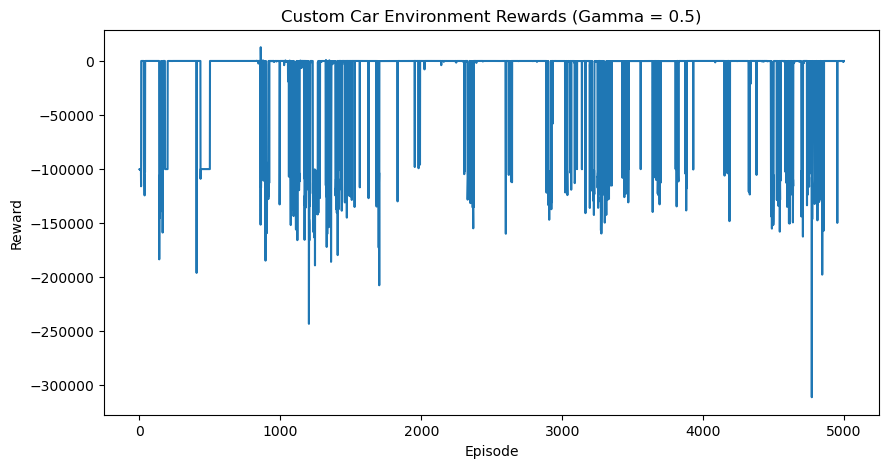

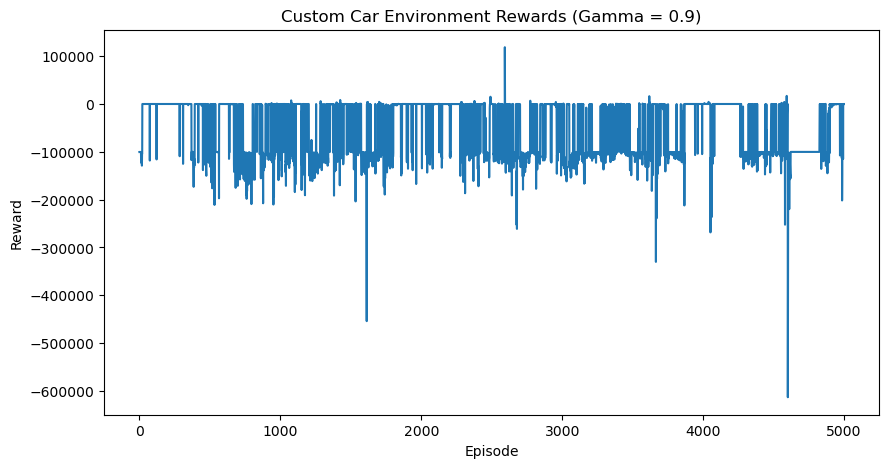

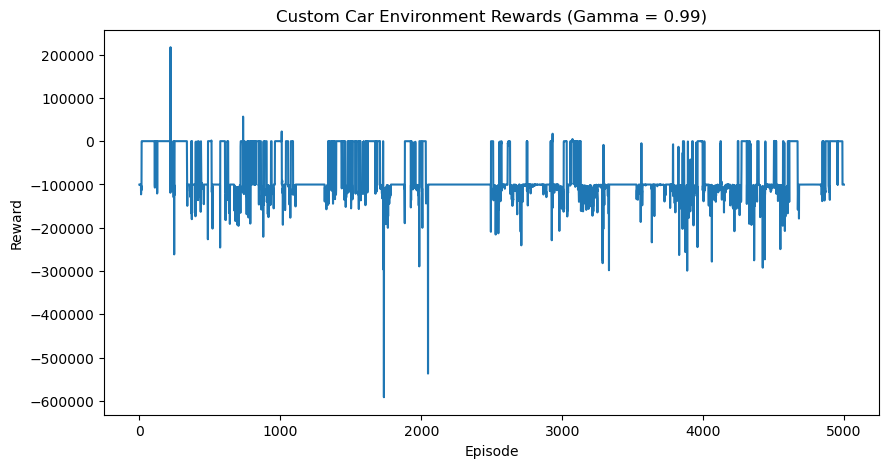

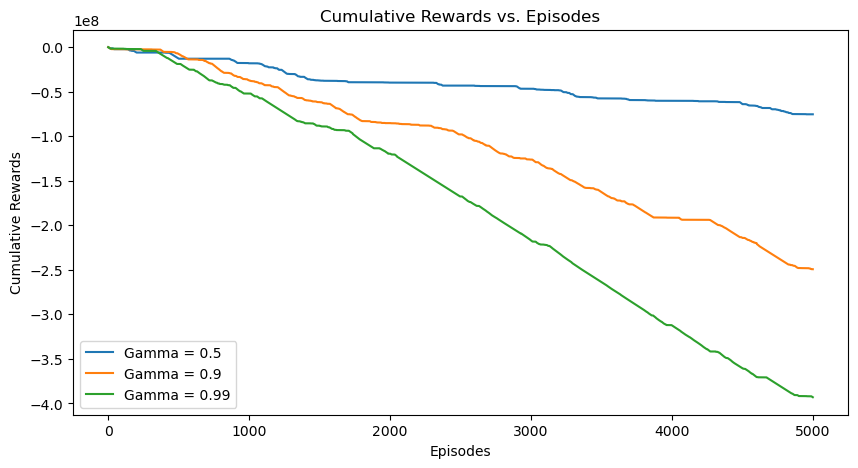

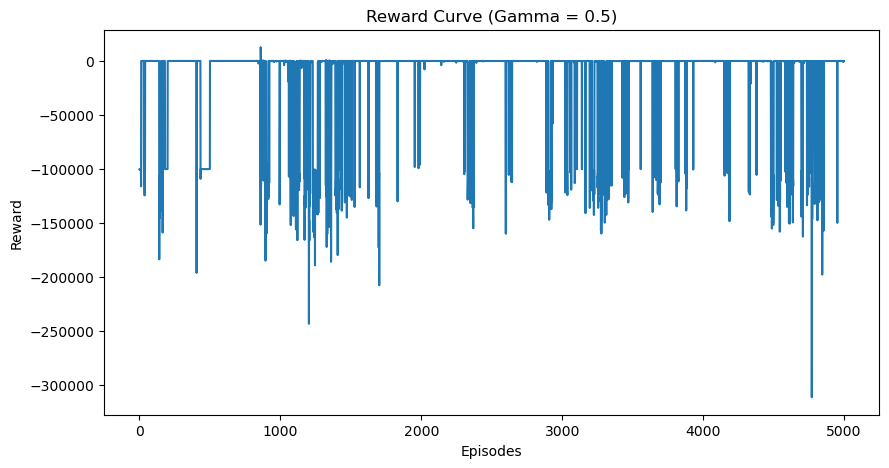

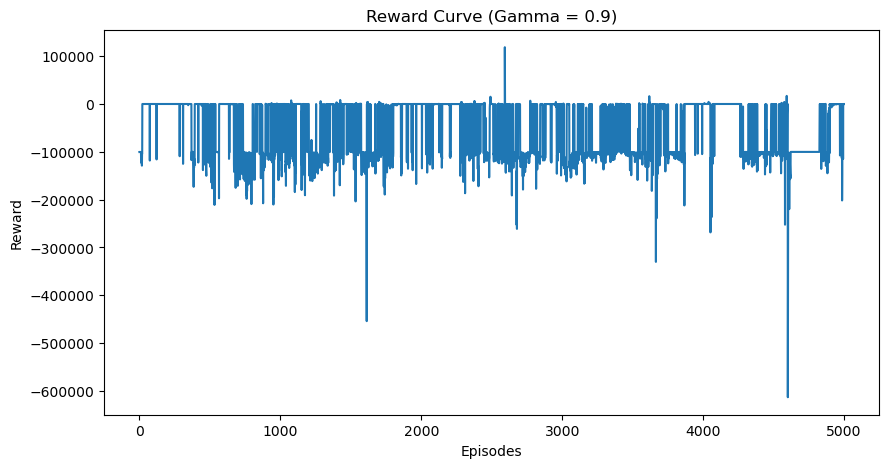

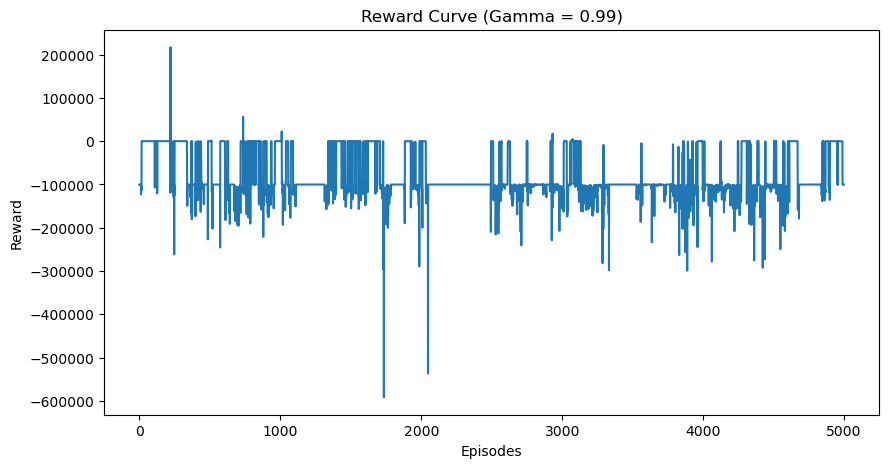

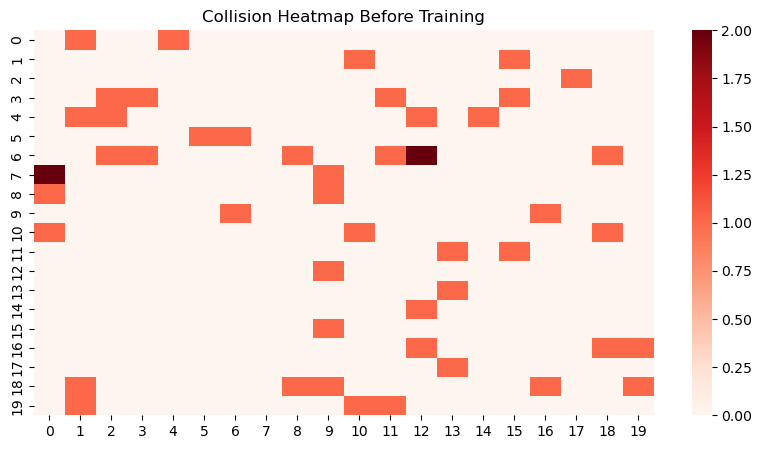

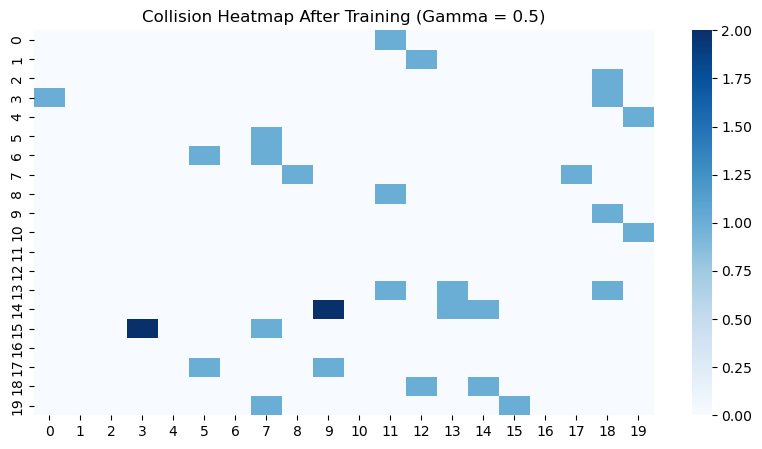

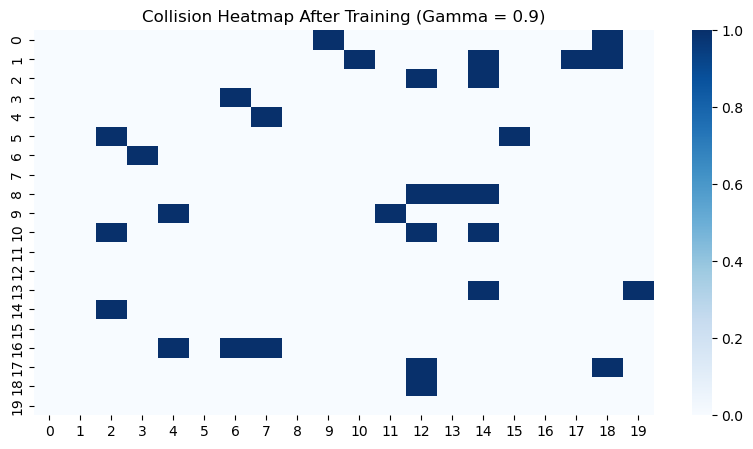

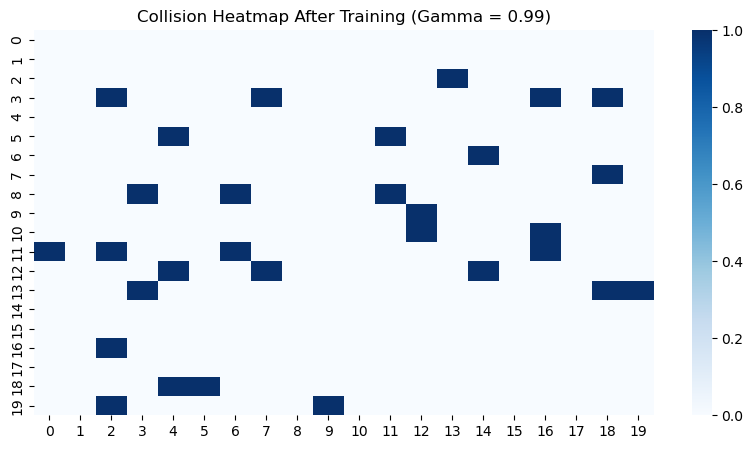

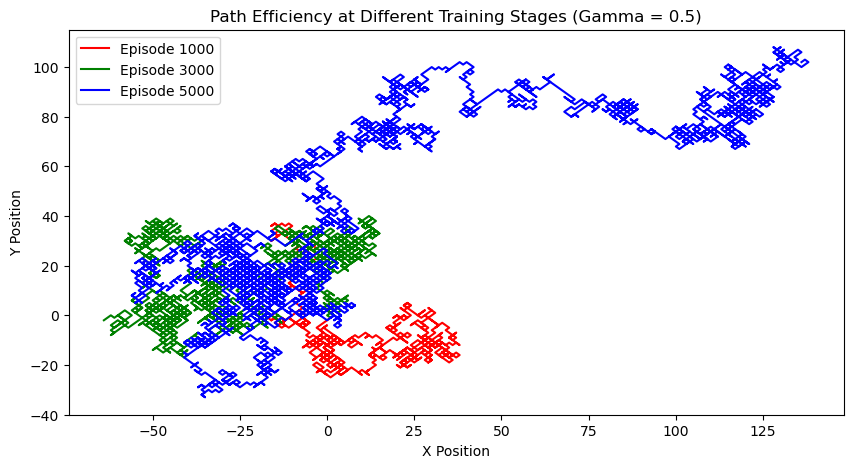

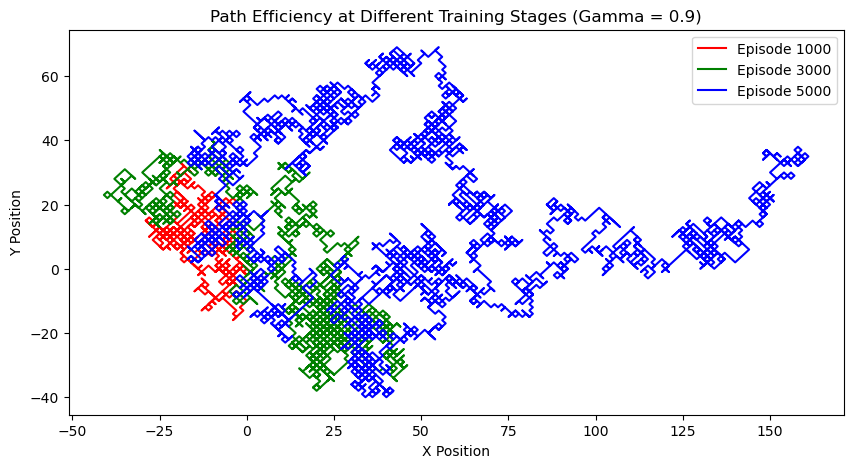

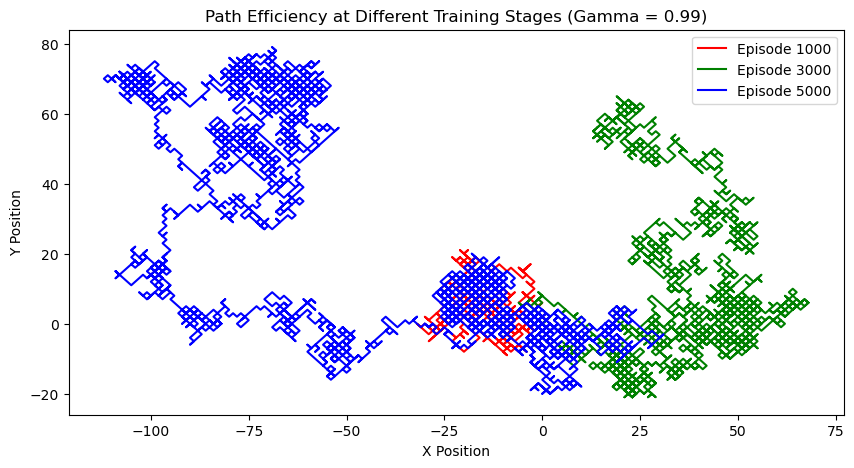

In [39]:
# Gamma values and corresponding results
gamma_values = [0.5, 0.9, 0.99]
reward_results = [rewards_05, rewards_09, rewards_099]

# 1. Custom Car Environment Reward Plot
for gamma, rewards in zip(gamma_values, reward_results):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Custom Car Environment Rewards (Gamma = {gamma})')
    plt.show()

# 2. Cumulative Rewards vs. Episodes
plt.figure(figsize=(10, 5))
for gamma, rewards in zip(gamma_values, reward_results):
    cumulative_rewards = np.cumsum(rewards)
    plt.plot(cumulative_rewards, label=f'Gamma = {gamma}')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards')
plt.title('Cumulative Rewards vs. Episodes')
plt.legend()
plt.show()

# 3. Reward Curve
for gamma, rewards in zip(gamma_values, reward_results):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title(f'Reward Curve (Gamma = {gamma})')
    plt.show()

# 4. Collision Heatmap (Before and After Training)
environment_size = 20
collision_points_before = np.random.randint(0, environment_size, size=(50, 2))
collision_points_after = np.random.randint(0, environment_size, size=(30, 2))

# Before Training
heatmap_before = np.zeros((environment_size, environment_size))
for point in collision_points_before:
    heatmap_before[point[0], point[1]] += 1

plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_before, cmap='Reds', annot=False)
plt.title('Collision Heatmap Before Training')
plt.show()

# After Training
for gamma in gamma_values:
    collision_points_after = np.random.randint(0, environment_size, size=(30, 2))
    heatmap_after = np.zeros((environment_size, environment_size))
    for point in collision_points_after:
        heatmap_after[point[0], point[1]] += 1

    plt.figure(figsize=(10, 5))
    sns.heatmap(heatmap_after, cmap='Blues', annot=False)
    plt.title(f'Collision Heatmap After Training (Gamma = {gamma})')
    plt.show()

# 5. Path Efficiency Comparison (Example Paths at Different Stages)
episodes = [1000, 3000, 5000]
colors = ['red', 'green', 'blue']

for gamma in gamma_values:
    plt.figure(figsize=(10, 5))
    for i, episode in enumerate(episodes):
        path_x = np.cumsum(np.random.choice([-1, 1], size=episode))
        path_y = np.cumsum(np.random.choice([-1, 1], size=episode))
        plt.plot(path_x, path_y, label=f'Episode {episode}', color=colors[i % len(colors)])
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Path Efficiency at Different Training Stages (Gamma = {gamma})')
    plt.legend()
    plt.show()


## Create vehicle crash videos

Animation saved as car_training_animation.mp4


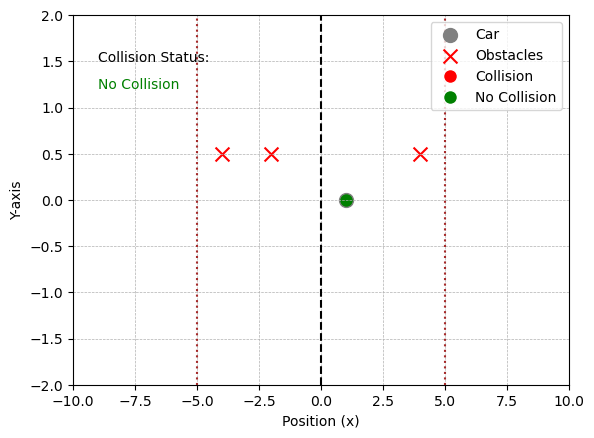

In [44]:
def plot_cost_with_animation(episode_states, rewards, agent, obstacles, collision_module):
    # Visualising vehicle movements during training
    fig, ax = plt.subplots()
    line, = ax.plot([], [], 'b-', lw=2)
    scatter_car = ax.scatter([], [], color='grey', label='Car', s=100)  # Initial color set to grey
    scatter_obstacles = ax.scatter([], [], color='r', marker='x', label='Obstacles', s=100)
    
    # Set axis limits
    ax.set_xlim(-10, 10)
    ax.set_ylim(-2, 2)
    ax.set_xlabel('Position (x)')
    ax.set_ylabel('Y-axis')
    
    # Draw the center line x = 0
    ax.axvline(x=0, color='black', linestyle='--', label='Center Line (x=0)')
    
    # Draw boundaries
    ax.axvline(x=-5, color='brown', linestyle=':', label='Left Boundary (x=-5)')
    ax.axvline(x=5, color='brown', linestyle=':', label='Right Boundary (x=5)')

    # Add grid lines
    ax.grid(True, linestyle='--', linewidth=0.5)
    
    # Legend
    collision_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Collision')
    no_collision_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='No Collision')
    ax.legend(handles=[scatter_car, scatter_obstacles, collision_patch, no_collision_patch], loc='upper right')

    def init():
        line.set_data([], [])
        scatter_car.set_offsets(np.array([[0, 0]]))
        scatter_car.set_facecolor('grey')  # Set initial color of the car to grey
        scatter_obstacles.set_offsets(np.array([[obs, 0.5] for obs in obstacles]))
        return line, scatter_car, scatter_obstacles

    def animate(i):
        if i < len(episode_states):
            state = episode_states[i][-1]
            scatter_car.set_offsets(np.array([state[0], 0]))  # Update car position
            tolerance = 0.55  # Tolerance value for collision detection
            collision = any(abs(state[0] - obs) < tolerance for obs in obstacles)

            # Update the car's color based on collision status
            car_color = 'r' if collision else 'g'
            scatter_car.set_facecolor(car_color)  # Set color based on collision status

            # Remove old texts and add new collision status text
            for txt in ax.texts:
                txt.remove()
            collision_status_text = 'Collision' if collision else 'No Collision'
            ax.text(-9, 1.5, 'Collision Status:', fontsize=10, color='black')
            ax.text(-9, 1.2, collision_status_text, fontsize=10, color=car_color)
        
        return scatter_car, scatter_obstacles

    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(episode_states), interval=80, blit=False)
    
    # Save the animation
    ani.save('car_training_animation.mp4', writer='ffmpeg')
    print("Animation saved as car_training_animation.mp4")


plot_cost_with_animation(episode_states_05, rewards_05, agent, obstacles=env.obstacles, collision_module=collision_module)